# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Импорты

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing
from sklearn import utils

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

### Функции

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
def distribution_overview(dFrame, attribute, title, scale=0.028, bns=None):
    mean = round(dFrame[attribute].mean(), 2)
    median = dFrame[attribute].median()
    mode = dFrame[attribute].mode()[0]
    min = dFrame[attribute].min()
    max = dFrame[attribute].max()
    q25 = dFrame[attribute].quantile(0.25)
    q75 = dFrame[attribute].quantile(0.95)
    q01 = dFrame[attribute].quantile(0.005)
    q99 = dFrame[attribute].quantile(0.995)

    plt.figure(figsize = (12, 8))
    sns.distplot(dFrame.loc[dFrame[attribute].notnull(), attribute], bins=bns)

    y = np.linspace(0, scale, 100)
    plt.plot([mean]*100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([median]*100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([mode]*100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title(title)
    plt.legend()

    print(f'min: {min}, quantile 0,01: {q01}, quantile 0,25: {q25}, mean: {mean}, median: {median}, mode: {mode}, quantile 0,75: {q75}, quantile 0,99: {q99}, max: {max}')

    plt.show()

### Описание датасета

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Файло

In [4]:
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
TEST_DATASET_PATH = 'test.csv'

In [6]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [7]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [8]:
DF_TEST_RESULT_DATASET_PATH = 'df_test_res.csv'

### Загрузка данных

In [9]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов данных

### Тренировочный набор

In [11]:
train.shape

(10000, 20)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [13]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [14]:
train['Rooms'].dtype

dtype('float64')

In [15]:
train['Rooms'] = train['Rooms'].astype('int64')

In [16]:
train['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [17]:
train['HouseFloor'].dtype

dtype('float64')

In [18]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')

In [19]:
train['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [20]:
train['KitchenSquare'].dtype

dtype('float64')

In [21]:
train['KitchenSquare'] = train['KitchenSquare'].astype('int64')

In [22]:
train['KitchenSquare'].dtype

dtype('int64')

### Тестовый набор

In [23]:
test.shape

(5000, 19)

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [25]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

Количество комнат должно быть целым числом.

In [26]:
test['Rooms'].dtype

dtype('float64')

In [27]:
test['Rooms'] = test['Rooms'].astype('int64')

In [28]:
test['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [29]:
test['HouseFloor'].dtype

dtype('float64')

In [30]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [31]:
test['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [32]:
test['KitchenSquare'].dtype

dtype('float64')

In [33]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [34]:
test['KitchenSquare'].dtype

dtype('int64')

### Объединение наборов для предварительной обработки

Объединим оба набора для вычищения данных.

In [35]:
df = pd.concat((train, test), sort=False).reset_index(drop=True)

In [36]:
df.shape

(15000, 20)

### Статистика

In [37]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор количественных переменных

In [38]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Обзор номинативных переменных

In [39]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [40]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [41]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [42]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка пропусков

In [43]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [44]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

1    1285
2    1271
3     577
4      15
0       3
5       2
6       1
Name: Rooms, dtype: int64

In [45]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

1977    2757
2016     102
2015      89
2017      87
2014      62
2018      33
2013      11
2019      10
2020       2
2012       1
Name: HouseYear, dtype: int64

In [46]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [47]:
df.loc[df['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0,49.483501,NaN,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
12071,10793,23,6,110.750226,NaN,0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN


Заполним оставшееся пустое значение в зависимости от среза по площади.

In [48]:
df.loc[df['Id'] == 770, 'LifeSquare'] = df.loc[df['Square'].between(49.0, 50.0), 'Rooms'].median()

In [49]:
df.loc[df['Id'] == 10793, 'LifeSquare'] = df.loc[df['Square'].between(100.0, 120.0), 'Rooms'].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [50]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [51]:
values = sorted(values)

In [52]:
length = len(values)

In [53]:
length

79

In [54]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [55]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [56]:
b = df.loc[df['Healthcare_1'].isnull()]

In [57]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [58]:
df['Ecology_2'].mode()[0]

'B'

In [59]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [60]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

**Ecology_3**

In [61]:
df['Ecology_3'].mode()[0]

'B'

In [62]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [63]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

**Shops_2**

In [64]:
df['Shops_2'].mode()[0]

'B'

In [65]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [66]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка выбросов

In [67]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,38.524649,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1251.831867,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,63.498418,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1126.030762,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,25.611946,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,33.768078,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,49.113026,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1894.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Почти все признаки имеют выбросы.

In [68]:
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,B,B,33,7976,5,35.0,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3,80.384479,46.683720,12,5,17,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2,62.254114,37.160377,7,3,5,1960,0.460556,B,B,20,4386,14,320.0,1,5,B,296021.204377
7,11993,74,2,80.312926,53.983730,0,14,0,1977,0.075779,B,B,6,1437,3,4702.0,0,2,B,221244.156664
8,5172,1,2,64.511437,53.983730,1,9,17,1977,0.007122,B,B,1,264,0,4849.0,0,1,B,229102.795999
9,8649,23,1,46.461409,18.915552,8,13,17,2014,0.075779,B,B,6,1437,3,4508.0,0,2,B,95380.220993


In [69]:
df.tail(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14990,15706,94,2,47.776485,27.920873,6,8,9,1970,0.282798,B,B,33,8667,2,80.0,0,6,B,NaN
14991,2105,64,2,45.493240,32.022565,6,4,9,1974,0.135650,B,B,46,7960,6,350.0,3,11,B,NaN
14992,7220,96,3,80.182493,48.627326,10,10,17,2003,0.041116,B,B,53,14892,4,990.0,1,4,B,NaN
14993,14562,113,2,46.627882,27.058739,5,6,5,1969,0.307467,B,A,30,5048,9,325.0,2,5,B,NaN
14994,6836,39,2,45.131282,30.780551,6,2,5,1965,0.428826,B,B,25,5011,8,730.0,0,2,B,NaN
14995,8180,11,3,67.133911,50.809797,6,5,9,1973,0.000170,B,B,36,5992,0,770.0,1,1,B,NaN
14996,4695,1,1,40.198472,21.807061,10,12,17,2017,0.007122,B,B,1,264,0,645.0,0,1,B,NaN
14997,5783,12,3,77.842178,48.282625,9,23,22,1989,0.090799,B,B,74,19083,2,562.0,5,15,B,NaN
14998,4780,62,2,81.305222,53.983730,0,4,0,1977,0.072158,B,B,2,629,1,100.0,0,0,A,NaN
14999,12504,30,2,60.555693,53.983730,1,10,17,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN


**Районы (DistrictId)**

In [70]:
df.sort_values(by="DistrictId", inplace=True)

In [71]:
df.loc[df['DistrictId'].notnull(), 'DistrictId']

8969       0
4374       0
2853       0
9840       0
5577       0
        ... 
13194    209
7650     209
11043    210
12666    211
10051    212
Name: DistrictId, Length: 15000, dtype: int64

In [72]:
df.loc[df['DistrictId'].notnull(), 'DistrictId'].value_counts()

27     1242
1       996
23      829
6       768
9       426
       ... 
212       1
117       1
174       1
198       1
207       1
Name: DistrictId, Length: 212, dtype: int64

min: 0, quantile 0,01: 1.0, quantile 0,25: 20.0, mean: 50.69, median: 37.0, mode: 27, quantile 0,75: 140.0, quantile 0,99: 189.0, max: 212


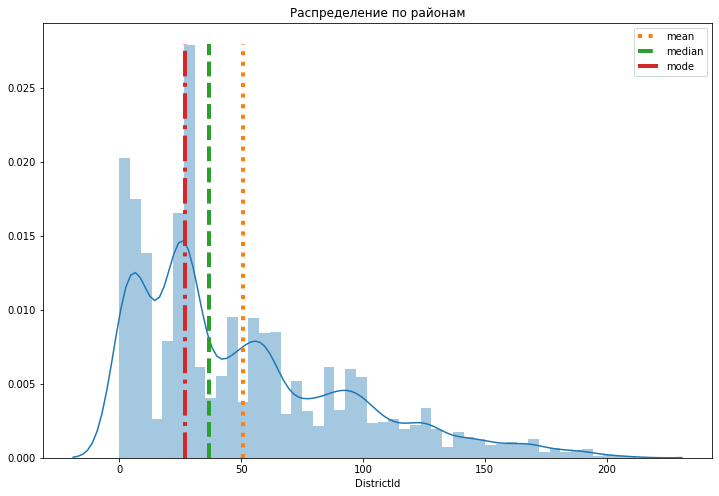

In [73]:
distribution_overview(df, 'DistrictId', 'Распределение по районам', 0.028)

Распределение по районам без особых выбросов.

**Распределение по комнатам (Rooms)**

In [74]:
df['Rooms'].unique()

array([ 2,  3,  1,  4, 19,  0,  5, 10,  6, 17], dtype=int64)

In [75]:
df.sort_values(by="Rooms", inplace=True)

In [76]:
df.loc[df['Rooms'].notnull(), 'Rooms']

3911      0
1397      0
4366      0
6149      0
12524     0
         ..
13217     6
377      10
8849     10
13398    17
1454     19
Name: Rooms, Length: 15000, dtype: int64

In [77]:
df.loc[df['Rooms'].notnull(), 'Rooms'].value_counts()

2     5910
1     5474
3     3334
4      240
5       25
0       10
6        3
10       2
19       1
17       1
Name: Rooms, dtype: int64

Есть выбросы для квартир к количеством комнат: 0, 6, 10, 19, 17

In [78]:
df.loc[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0,49.483501,2.000000,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
1397,12638,27,0,138.427694,136.215499,0,4,3,2016,0.075424,B,B,11,3097,0,4849.0,0,0,B,268394.744389
4366,456,6,0,81.491446,63.973134,0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
6149,3159,88,0,38.697117,19.345131,9,9,16,1982,0.127376,B,B,43,8429,3,1937.0,3,9,B,158998.110646
12524,10729,27,0,76.345154,42.820796,12,14,0,1977,0.017647,B,B,2,469,0,990.0,0,0,B,NaN
8834,9443,27,0,87.762616,85.125471,0,5,15,1977,0.211401,B,B,9,1892,0,320.0,0,1,B,219281.918007
4853,3224,27,0,2.377248,0.873147,0,1,0,1977,0.017647,B,B,2,469,0,1815.0,0,0,B,126596.941798
2269,7317,27,0,41.790881,63.973134,0,13,0,1977,0.211401,B,B,9,1892,0,1145.0,0,1,B,98129.976788
1981,7917,27,0,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,2500.0,0,1,B,302211.260887
12406,3343,58,0,116.824201,113.692424,0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,NaN


In [79]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] < 45.0), 'Rooms'] = 1

In [80]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [81]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(65.0, 85.0), 'Rooms'] = 3

In [82]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(85.0, 105.0), 'Rooms'] = 4

In [83]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] > 106), 'Rooms'] = 5

In [84]:
df.loc[df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2170,14003,99,6,59.414334,38.702244,6,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
12071,10793,23,6,110.750226,3.000000,0,2,2,2015,0.014073,B,B,2,475,0,1084.0,0,0,B,NaN
13217,4058,27,6,223.453689,104.113552,16,2,2,2017,0.041116,B,B,53,14892,4,1015.0,1,4,B,NaN


In [85]:
df.loc[(df['Rooms'] == 6) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [86]:
df.loc[(df['Rooms'] == 6) & (df['Square'] > 106), 'Rooms'] = 5

In [87]:
df.loc[df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056975,36.223072,10,22,22,2002,0.090799,B,B,74,19083,2,100.0,5,15,B,317265.323792
8849,14865,9,10,60.871266,38.420681,10,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [88]:
df.loc[df['Rooms'] == 10, 'Rooms'] = 2

In [89]:
df.loc[df['Rooms'] == 19]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19,42.006046,21.779288,7,17,17,2014,0.007122,B,B,1,264,0,1406.0,0,1,B,78364.616704


In [90]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

In [91]:
df.loc[df['Rooms'] == 17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
13398,1435,111,17,52.866107,32.528342,8,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B,NaN


In [92]:
df.loc[df['Rooms'] == 17, 'Rooms'] = 2

In [93]:
df['Rooms'].unique()

array([2, 5, 3, 1, 4], dtype=int64)

min: 1, quantile 0,01: 1.0, quantile 0,25: 1.0, mean: 1.9, median: 2.0, mode: 2, quantile 0,75: 3.0, quantile 0,99: 4.0, max: 5


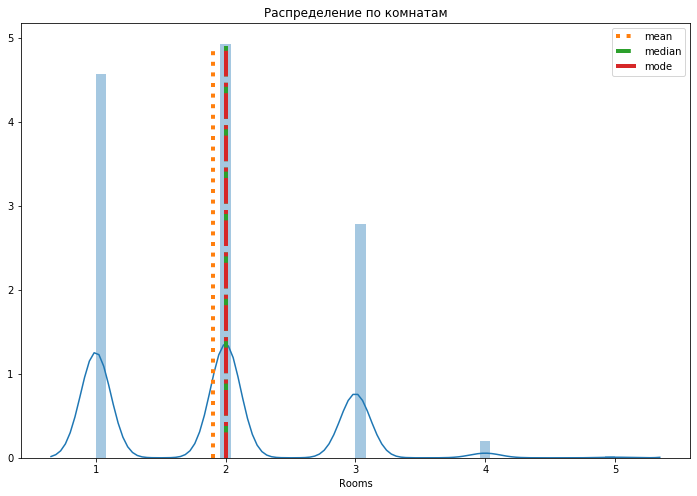

In [94]:
distribution_overview(df, 'Rooms', 'Распределение по комнатам', 4.9)

**Общая площадь квартиры (Square)**

In [95]:
df.sort_values(by="Square", inplace=True)

In [125]:
m_2_Price = pd.DataFrame({'Id':list(df.loc[df['Price'].notnull(), 'Id']), 'm_2_Price':list(df.loc[df['Price'].notnull(), 'Square'] / df.loc[df['Price'].notnull(), 'Price'])})

In [126]:
m_2_Price

,Id,m_2_Price
0,14786,0.000006
1,15744,0.000004
2,3224,0.000019
3,10202,0.000019
4,6782,0.000007
...,...,...
9995,7917,0.000705
9996,5548,0.000605
9997,2307,0.000387
9998,28,0.000336


min: 4.339081178854126e-06, quantile 0,01: 0.00012288337125399384, quantile 0,25: 0.0002131116523673229, mean: 0.0, median: 0.0002557510524445752, mode: 4.339081178854126e-06, quantile 0,75: 0.0004982094857802143, quantile 0,99: 0.0007530390686168538, max: 0.0012102913037660484


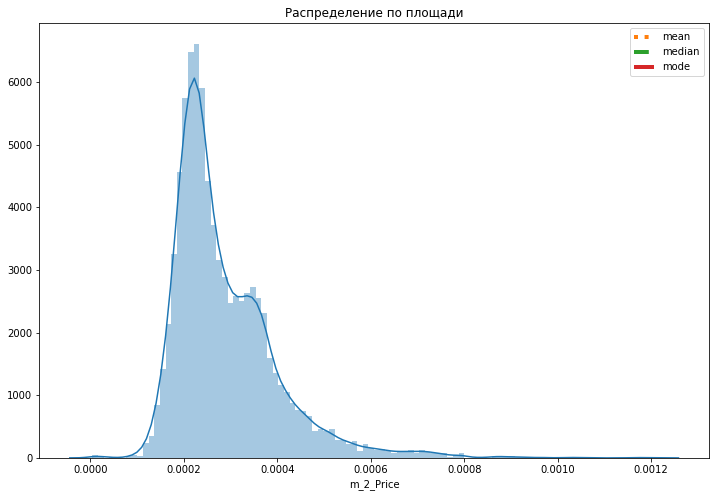

In [128]:
distribution_overview(m_2_Price, 'm_2_Price', 'Распределение по площади', 0.0062, 100)

In [129]:
id_list = list(m_2_Price.loc[m_2_Price['m_2_Price'] > 0.0008, 'Id'])

In [130]:
id_list

[13237,
 11854,
 8935,
 671,
 7243,
 7439,
 16148,
 16308,
 9358,
 13220,
 15849,
 9726,
 8292,
 13227,
 8897,
 6944,
 9631,
 16662,
 14892,
 1395,
 1437,
 4074,
 6627,
 14825,
 7590,
 203]

In [131]:
df.loc[df['Id'].isin(id_list)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9732,13237,144,2,54.0,30.547287,8,2,14,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
1622,11854,9,2,54.0,29.914386,8,4,14,2004,0.130123,B,B,8,1986,0,810.0,0,0,B,62126.665619
5813,8935,47,2,58.0,30.587406,9,17,17,2010,0.197368,B,B,8,2423,1,32.0,0,1,B,66722.596920
522,671,23,2,58.0,54.177713,10,3,17,2015,0.005767,B,B,1,388,0,900.0,0,0,B,63900.205590
3605,7243,9,2,61.0,52.460857,8,5,22,1981,0.136244,B,B,11,2370,0,1020.0,0,1,B,59877.592523
1884,7439,27,2,58.0,33.767600,12,3,17,2014,0.072158,B,B,2,629,1,770.0,0,0,A,67343.133878
2410,16148,19,2,61.0,30.289514,13,9,15,2009,0.309479,B,B,35,7715,4,990.0,0,6,B,72430.588440
6652,16308,41,3,62.0,43.481274,6,9,9,1974,0.175055,B,B,36,10055,3,2729.0,1,0,B,74740.392487
6007,9358,25,3,62.0,40.612146,7,3,5,1983,0.069753,B,B,53,13670,4,2729.0,1,11,B,64298.216337
8517,13220,1,3,87.0,45.434909,6,3,3,1958,0.036270,B,B,6,1318,1,200.0,1,1,B,83511.829064


In [124]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

In [ ]:
df.loc[df['Square'].notnull(), 'Square']

Округлим значения до целого.

In [ ]:
df['Square'] = round(df['Square'],0)

In [ ]:
df['LifeSquare'] = round(df['LifeSquare'],0)

In [ ]:
square_unique = df['Square'].unique()
square_unique

In [ ]:
plt.figure(figsize = (12, 8))
sns.kdeplot(square_unique)

In [ ]:
plt.figure(figsize = (12, 8))
plt.hist(square_unique, bins=50)

In [ ]:
square_count = df.loc[df['Square'].notnull(), 'Square'].value_counts(sort=False)
square_count

In [ ]:
square_distrib = pd.DataFrame({'Square':list(square_unique), 'Count':list(square_count)})

In [ ]:
distribution_overview(square_distrib, 'Square', 'Распределение по площади', 0.0062, 50)

После 170 есть явно какие-то выбросы.

In [ ]:
df.loc[df['Square'] > 170, 'Square'].value_counts()

In [ ]:
df.loc[df['Square'] > 170]

In [ ]:
id_list = list(df['Id'][df['Square'] > 170])

In [ ]:
for id in id_list:
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Расмотрим для 1-комнатных квартир**

In [ ]:
df.loc[df['Rooms'] == 1]

In [ ]:
distribution_overview(df.loc[df['Rooms'] == 1], 'Square', 'Распределение по площади', 0.11, 100)

In [ ]:
len(df.loc[(df['Rooms'] == 1) & (df['Square'] > 102)])

In [ ]:
len(df.loc[(df['Rooms'] == 1) & (df['Square'] < 19)])

In [ ]:
id_list = list(df['Id'][((df['Rooms'] == 1) & (df['Square'] > 102)) | ((df['Rooms'] == 1) & (df['Square'] < 19))])

In [ ]:
for id in id_list:
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == 1) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Расмотрим для 2-комнатных квартир**

In [ ]:
df.loc[df['Rooms'] == 2]

In [ ]:
distribution_overview(df.loc[df['Rooms'] == 2], 'Square', 'Распределение по площади', 0.0456, 70)

In [ ]:
len(df.loc[(df['Rooms'] == 2) & (df['Square'] > 92)])

In [ ]:
len(df.loc[(df['Rooms'] == 2) & (df['Square'] < 37)])

In [ ]:
id_list = list(df['Id'][((df['Rooms'] == 2) & (df['Square'] > 92)) | ((df['Rooms'] == 2) & (df['Square'] < 37))])

In [ ]:
for id in id_list:
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == 2) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Расмотрим для 3-комнатных квартир**

In [ ]:
df.loc[df['Rooms'] == 3]

In [ ]:
distribution_overview(df.loc[df['Rooms'] == 3], 'Square', 'Распределение по площади', 0.069, 70)

In [ ]:
len(df.loc[(df['Rooms'] == 3) & (df['Square'] > 138)])

In [ ]:
len(df.loc[(df['Rooms'] == 3) & (df['Square'] < 46)])

In [ ]:
id_list = list(df['Id'][((df['Rooms'] == 3) & (df['Square'] > 138)) | ((df['Rooms'] == 3) & (df['Square'] < 46))])

In [ ]:
for id in id_list:
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    result = df['Square'][(df['Rooms'] == 3) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'Square'] = round(result,0)

**Расмотрим для 4-комнатных квартир**

In [ ]:
df.loc[df['Rooms'] == 4]

In [ ]:
distribution_overview(df.loc[df['Rooms'] == 4], 'Square', 'Распределение по площади', 0.06, 70)

In [ ]:
df.loc[((df['Rooms'] == 4) & (df['Square'] > 170)) | ((df['Rooms'] == 4) & (df['Square'] < 47)), 'Square'] = round(df['Square'][(df['Rooms'] == 4) & (df['HouseYear'] != 1977)].median(),0)

**Расмотрим для 5-комнатных квартир**

In [ ]:
df.loc[df['Rooms'] == 5]

In [ ]:
distribution_overview(df.loc[df['Rooms'] == 5], 'Square', 'Распределение по площади', 0.018, 70)

In [ ]:
df.loc[((df['Rooms'] == 5) & (df['Square'] > 265)) | ((df['Rooms'] == 5) & (df['Square'] < 47)), 'Square'] = round(df['Square'][(df['Rooms'] == 5) & (df['HouseYear'] != 1977)].median(),0)

In [ ]:
distribution_overview(df, 'Square', 'Распределение по площади', 0.042, 70)

**Жилая площадь квартиры (LifeSquare)**

In [ ]:
df.sort_values(by="LifeSquare", inplace=True)

In [ ]:
df.tail(20)

In [ ]:
df.loc[df['Id'] == 16550, 'LifeSquare'] = 81

In [ ]:
df.loc[df['Id'] == 11602, 'LifeSquare'] = 38

In [ ]:
df.loc[df['Id'] == 15886, 'LifeSquare'] = 61

In [ ]:
df.loc[df['Id'] == 2307, 'LifeSquare'] = 21

In [ ]:
df.loc[df['Id'] == 11533, 'LifeSquare'] = 30

In [ ]:
df.loc[df['Square'] < df['LifeSquare']]

In [ ]:
id_list = list(df['Id'][df['Square'] < df['LifeSquare']])

In [ ]:
for id in id_list:
    floor = list(df['HouseFloor'][df['Id'] == id])[0]
    rooms = list(df['Rooms'][df['Id'] == id])[0]
    result = df['LifeSquare'][(df['Rooms'] == rooms) & (df['HouseFloor'] == floor) & (df['HouseYear'] != 1977)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'LifeSquare'] = round(result,0)


In [ ]:
df.loc[df['Id'] == 14990, 'LifeSquare'] = 34

In [ ]:
df.loc[df['Id'] == 5548, 'LifeSquare'] = 94

In [ ]:
df.loc[df['Id'] == 7917, 'LifeSquare'] = 111

In [ ]:
df.loc[df['Id'] == 16568, 'LifeSquare'] = 92

In [ ]:
df.loc[(df['Square'] - df['LifeSquare']).between(-10, 0)]

In [ ]:
# df.loc[(df['Square'] - df['LifeSquare']).between(-10, -1), 'Square'], df.loc[(df['Square'] - df['LifeSquare']).between(-10, -1), 'LifeSquare'] = df.loc[(df['Square'] - df['LifeSquare']).between(-10, -1), 'LifeSquare'], df.loc[(df['Square'] - df['LifeSquare']).between(-10, -1), 'Square']

In [ ]:
distribution_overview(df, 'LifeSquare', 'Распределение по площади', 0.047)

**Площадь кухни (KitchenSquare)**

In [ ]:
df.sort_values(by="KitchenSquare", inplace=True)

In [ ]:
distribution_overview(df, 'KitchenSquare', 'Распределение по площади', 0.017)

In [ ]:
df.loc[(abs(df['Square'] - df['LifeSquare']) < df['KitchenSquare']) & (df['KitchenSquare'] > 1)]

In [ ]:
df.loc[df['Id'] == 14656, 'KitchenSquare'] = 1

In [ ]:
df.loc[df['Id'] == 14679, 'KitchenSquare'] = 5

In [ ]:
df.loc[df['Id'] == 14594, 'KitchenSquare'] = 5

In [ ]:
id_list = list(df['Id'][(abs(df['Square'] - df['LifeSquare']) < df['KitchenSquare']) & (df['KitchenSquare'] > 1)])

In [ ]:
for id in id_list:
    s = list(df['Square'][df['Id'] == id])[0]
    ls = list(df['LifeSquare'][df['Id'] == id])[0]
    df.loc[df['Id'] == id, 'Square'] = round(abs(s - ls) / 2,0)

In [ ]:
df.loc[df['KitchenSquare'] > 20]

### Отбор и построение новых признаков

In [ ]:
df.sort_values(by="Id", inplace=True)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [ ]:
# df.drop(['Id'],axis=1,inplace=True)

In [ ]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [ ]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [ ]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [ ]:
df.head()

Разобъем обратно набор данных df на 2 набора: тренировочный м икчирвый.

In [ ]:
df_train = df.loc[df['Price'].notnull()]

In [ ]:
df_test = df.loc[df['Price'].isnull()]

Сохраним эти наборы.

In [ ]:
df_train.to_csv(DF_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [ ]:
df_test.to_csv(DF_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [ ]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

In [ ]:
plt.figure(figsize = (12, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [ ]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

In [ ]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

In [ ]:
sns.pairplot(df_num_features);

In [ ]:
grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

In [ ]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

In [ ]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

In [ ]:
grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

In [ ]:
grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

In [ ]:
grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

In [ ]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

### Отбор признаков

In [ ]:
df_train.columns.tolist()

In [ ]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']
target_name = 'Price'

In [ ]:
df_train = df_train[feature_names + [target_name]]
df_train.head()

### Стандартизация признаков

In [ ]:
feature_names_for_stand = df_train[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

In [ ]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df_train[feature_names_for_stand])

In [ ]:
stand_features

In [ ]:
df_train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [ ]:
df_train.head()

### Сохранение обучающего датасета

In [ ]:
TRAIN_DATASET_PATH_ADD = 'df_train_add.csv'

In [ ]:
TEST_DATASET_PATH_ADD = 'df_test_add.csv'

In [ ]:
df_train.to_csv(TRAIN_DATASET_PATH_ADD, index=False, encoding='utf-8')

### Разбиение на train и test

In [ ]:
X = df_train[feature_names]
y = df_train[target_name]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение базовых моделей и выбор лучшей

**Linear Regression**

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [ ]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
# sorted(y_train_preds)

In [ ]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
y_test_preds

In [ ]:
lasso_model = Lasso(alpha=0.3)
lasso_model.fit(X_train, y_train)

In [ ]:
y_train_preds = lasso_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(X_train, y_train)

In [ ]:
y_train_preds = ridge_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lasso_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

In [ ]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

In [ ]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
X_train.dtypes

In [ ]:
y_train.dtypes

In [ ]:
# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_Y)

lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

# clf = LogisticRegression()
# clf.fit(training_data_X, training_scores_encoded)

In [ ]:
log_r_model = LogisticRegression(solver="liblinear")
log_r_model.fit(X_train, y_train_encoded)

In [ ]:
? LogisticRegression

In [ ]:
y_train_preds = log_r_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = log_r_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
X_test = df_test[feature_names]

In [ ]:
y_test_preds = rf_model.predict(X_test)

In [ ]:
y_test_preds

In [ ]:
df_res = pd.DataFrame({'Id':list(test['Id']),'Price':list(y_test_preds)})

In [ ]:
df_res.to_csv(DF_TEST_RESULT_DATASET_PATH, index=False, encoding='utf-8')